In [2]:
import os
import random

from collections import OrderedDict
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = [5, 5]
matplotlib.rcParams['figure.dpi'] = 200

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import torchvision.models as models

import cv2
#from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label


from data_helper import UnlabeledDataset, LabeledDataset
from helper import collate_fn, draw_box, compute_ts_road_map
from darknet import *
from utils import *

In [25]:
def combine_image(samples):
    out = []
    for sample in samples:
        frist = torch.cat( (sample[0], sample[1], sample[2]), 2)
        second = torch.cat( (sample[3], sample[4], sample[5]), 2)
        curr_image = torch.cat((frist, second),1).transpose(2,1).flip(2)
        
        trans = transforms.Compose([transforms.ToPILImage(), 
                                    transforms.Resize((800,800)),
                                    transforms.ToTensor()])
        comb = trans(curr_image)
        out.append(comb)
    return torch.stack(out)

In [6]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0);

device = 'cpu'
image_folder = '../data'
annotation_csv = '../data/annotation.csv'

labeled_scene_index = np.arange(106, 134)

train_index = np.arange(106,108)
val_index = np.arange(128,130)
transform = torchvision.transforms.ToTensor()

labeled_trainset = LabeledDataset(
    image_folder=image_folder,
    annotation_file=annotation_csv,
    scene_index=train_index,
    transform=transform,
    extra_info=False
    )

labeled_valset = LabeledDataset(
    image_folder=image_folder,
    annotation_file=annotation_csv,
    scene_index=val_index,
    transform=transform,
    extra_info=False
    )

trainloader = torch.utils.data.DataLoader(labeled_trainset, batch_size=2, shuffle=True, num_workers=2, collate_fn=collate_fn)
valloader = torch.utils.data.DataLoader(labeled_valset, batch_size=2, shuffle=True, num_workers=2, collate_fn=collate_fn)

torch.Size([2, 6, 3, 256, 306])
torch.Size([2, 3, 800, 800])


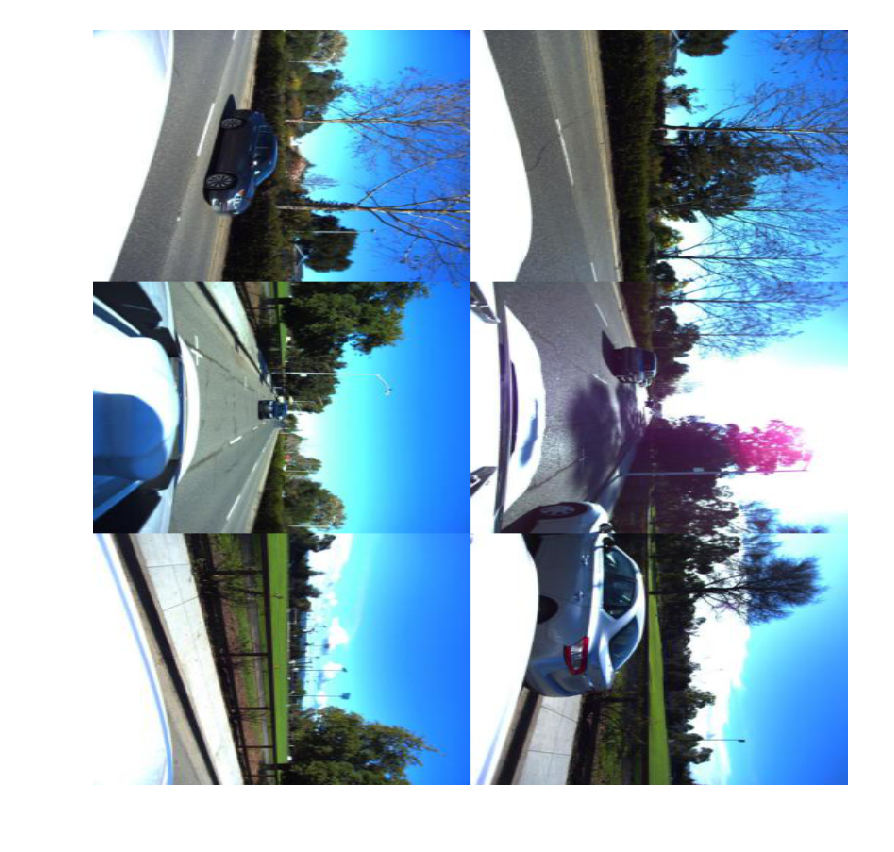

In [26]:

for i, (sample, target, road_img) in enumerate(trainloader):
    sample = torch.stack(sample)
    print(sample.shape)
    batch_size = sample.shape[0]
    test = combine_image(sample)
    print(test.shape)
    plt.imshow(test[0].numpy().transpose(1, 2, 0))
    plt.axis('off');
    break

In [35]:
model = Darknet('myYolo.cfg')
region_loss = model.loss
model.print_network()

layer     filters    size              input                output
    0 conv     32  3 x 3 / 1   800 x 800 x   3   ->   800 x 800 x  32
    1 conv     64  3 x 3 / 2   800 x 800 x  32   ->   400 x 400 x  64
    2 conv     32  1 x 1 / 1   400 x 400 x  64   ->   400 x 400 x  32
    3 conv     64  3 x 3 / 1   400 x 400 x  32   ->   400 x 400 x  64
    4 shortcut 1
    5 conv    128  3 x 3 / 2   400 x 400 x  64   ->   200 x 200 x 128
    6 conv     64  1 x 1 / 1   200 x 200 x 128   ->   200 x 200 x  64
    7 conv    128  3 x 3 / 1   200 x 200 x  64   ->   200 x 200 x 128
    8 shortcut 5
    9 conv     64  1 x 1 / 1   200 x 200 x 128   ->   200 x 200 x  64
   10 conv    128  3 x 3 / 1   200 x 200 x  64   ->   200 x 200 x 128
   11 shortcut 8
   12 conv    256  3 x 3 / 2   200 x 200 x 128   ->   100 x 100 x 256
   13 conv    128  1 x 1 / 1   100 x 100 x 256   ->   100 x 100 x 128
   14 conv    256  3 x 3 / 1   100 x 100 x 128   ->   100 x 100 x 256
   15 shortcut 12
   16 conv    128  1 x 1

AssertionError: 